In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
#from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.models import Model
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.17.0


In [ ]:

SEED = 42

# Dataset path
dataset_path = '/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/'
img_train = dataset_path + 'train/images/'
seg_train = dataset_path + 'train/labels/'

img_val = dataset_path + 'test/images/'
seg_val = dataset_path + 'test/labels/'

In [ ]:
import os
import random
from shutil import copyfile
648
# Set random seed for reproducibility
random.seed(42)

# Dataset path
dataset_path = '/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/'

img_train = dataset_path + 'train/images/'
seg_train = dataset_path + 'train/labels/'

img_val = dataset_path + 'val/images/'
seg_val = dataset_path + 'val/labels/'

img_test = dataset_path + 'test/images/'
# seg_test = dataset_path + 'test/labels/'

# Create directories if they don't exist
os.makedirs(img_val, exist_ok=True)
os.makedirs(seg_val, exist_ok=True)

# Get all training images
all_train_images = os.listdir(img_train)

# Shuffle images
random.shuffle(all_train_images)

# Split images into new training and validation sets
new_train_images = all_train_images[:647]
val_images = all_train_images[648:]

# Move validation images to the validation directory
for img_name in val_images:
    # Move image files
    copyfile(os.path.join(img_train, img_name), os.path.join(img_val, img_name))

    # Move corresponding label files
    seg_name = img_name.replace('images', 'labels')  # Adjust if filenames differ
    copyfile(os.path.join(seg_train, seg_name), os.path.join(seg_val, seg_name))




Sample Training Image

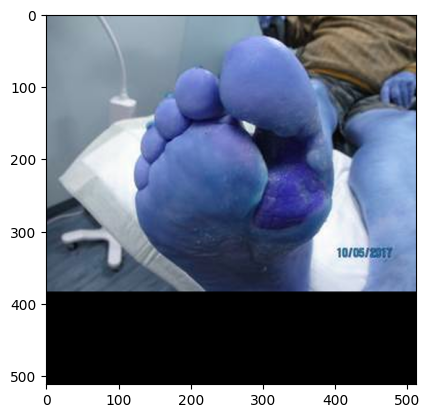

In [ ]:
# Reading a sample image and plotting it
img = cv2.imread(img_train+'0011.png',1)
plt.imshow(img)

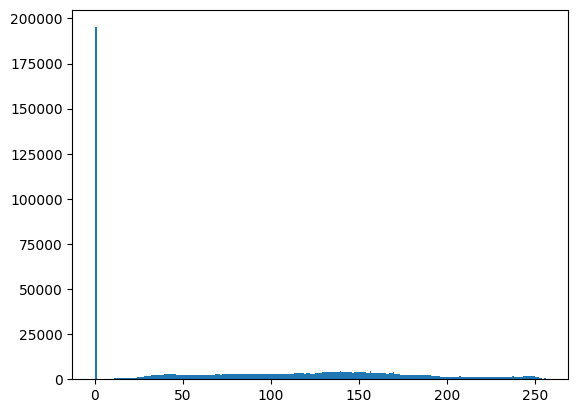

In [ ]:
# Plotting an Histogram to find the frequency of pixel intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

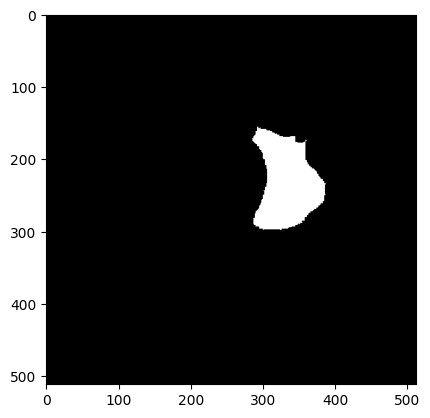

In [ ]:
# Reading the given annotated image for the above sample image
img = cv2.imread(seg_train+'0011.png',1)
plt.imshow(img)

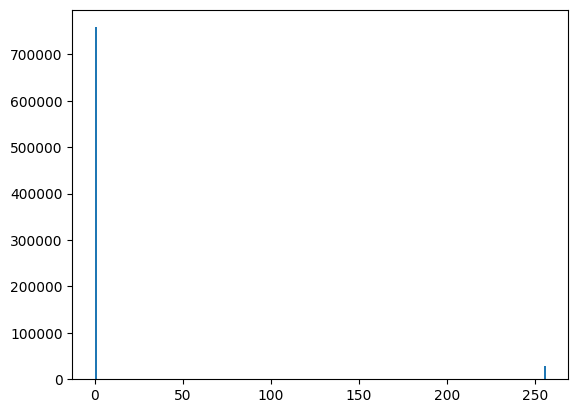

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii, y[ii])).T

array([[     0, 758604],
       [   255,  27828]])

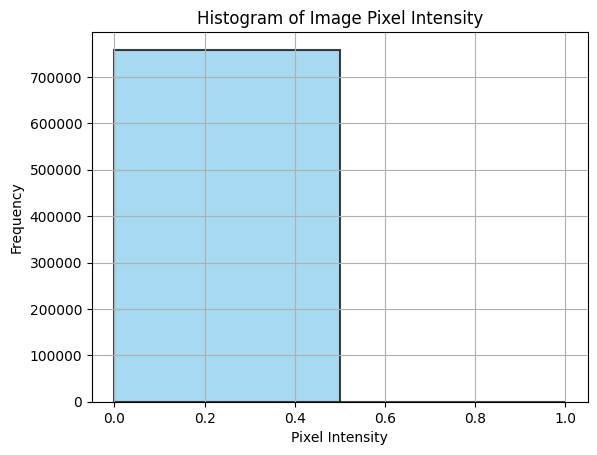

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
import matplotlib.pyplot as plt
plt.hist(img.ravel(), bins=2, range=[0,1], color='skyblue', edgecolor='black', alpha=0.75, linewidth=1.5)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Image Pixel Intensity')
plt.grid(True)
plt.show()

Plotting the annotated image after intensifying the pixels

In [ ]:

def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                # max value will be 6*40=240 which is under 255
                img_seg[i][j] *= 40
    return img_seg

In [ ]:
# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train+'0011.png')

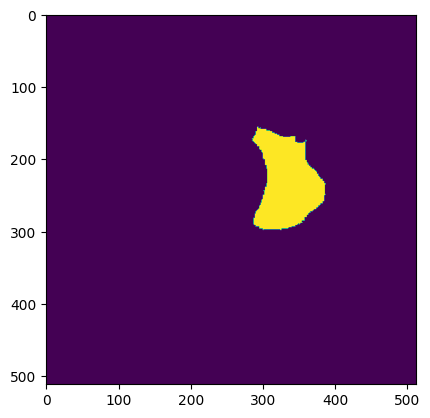

In [ ]:
# Plotting the processed segmentation image
plt.imshow(img_seg)

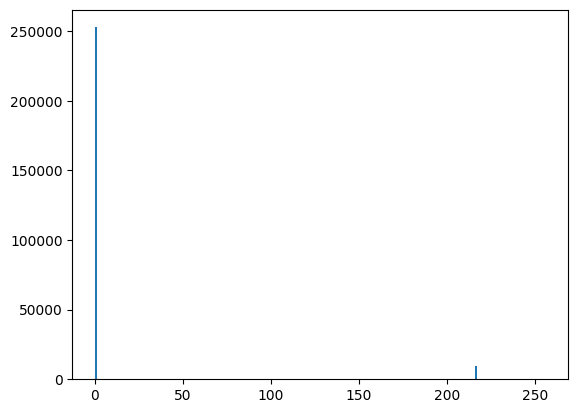

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,256])
plt.show()

Data Preparation

In [ ]:

# Image size that we are going to use
(HEIGHT,WIDTH) = (256,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 2

In [ ]:
import tensorflow as tf
import numpy as np

def parse_image(img_path):
    """
    Load an image and its annotation (mask) and return a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_path = tf.strings.regex_replace(img_path, "images", "labels")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", ".png")

    # Reading the annotation file corresponding to the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)


    mask = tf.where(mask == 255, np.dtype('uint8').type(1), mask)

    return {'image': image, 'segmentation_mask': mask}


In [ ]:


train_dataset = tf.data.Dataset.list_files(img_train + '*.png', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val + '*.png', seed=SEED)
val_dataset = val_dataset.map(parse_image)


In [ ]:


def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:


def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):

    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:


# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


Visualizing after processing the data

In [ ]:
def display_sample(display_list):

    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [ ]:
# Getting a sample image for visualizing
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

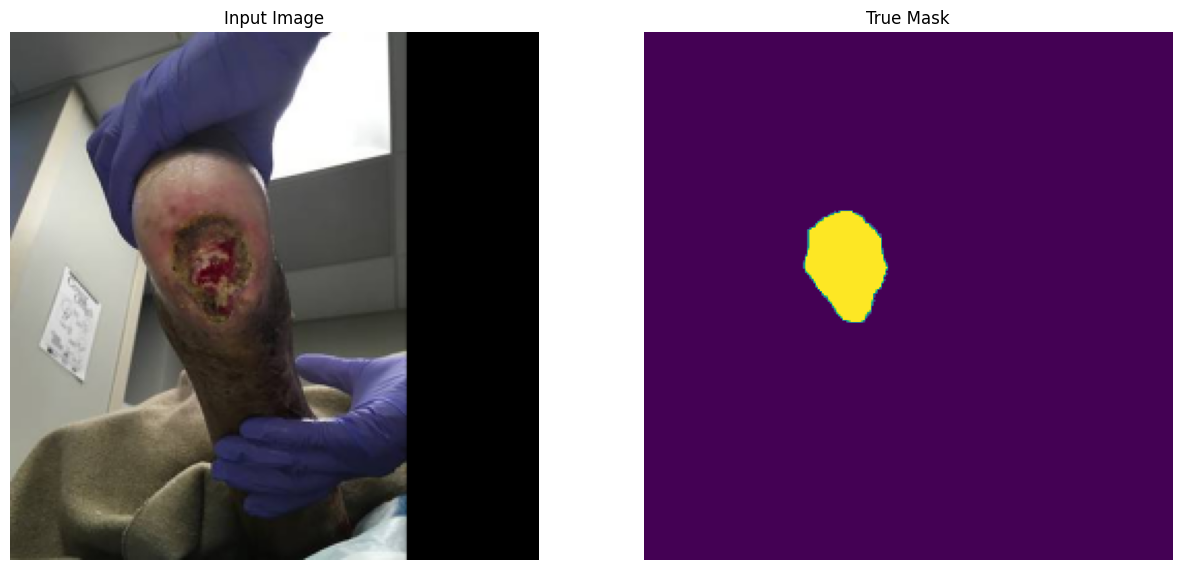

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[0], sample_mask[0]])



Model Building (my-net)

In [ ]:
input_shape = (256, 256, 3)

In [ ]:
inputs = Input(input_shape)

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**PyramidNet**

In [ ]:
def myblock(conv_image, pool_image):

    upsample = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(pool_image)
    concate = concatenate([conv_image, upsample])
    convo = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concate)

    return convo


In [ ]:
  def Pyramidnet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    #Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #256
    c1=resnet50.get_layer("conv1_relu").output
    p1=MaxPooling2D((2, 2))(c1)

    #128
    c2=resnet50.get_layer("conv2_block1_1_conv").output
    p2=MaxPooling2D((2, 2))(c2)

    #64
    c3=resnet50.get_layer("conv3_block1_1_conv").output
    p3=MaxPooling2D((2, 2))(c3)

    #32
    c4=resnet50.get_layer("conv4_block1_1_conv").output
    p4=MaxPooling2D((2, 2))(c4)


    #layer 1
    #c1 and c2
    a1=myblock(c1, c2)
    #c2 and c3
    a2=myblock(c2, c3)
    #c3 and c4
    a3=myblock(c3, c4)

    #layer2
    #a1 and a2
    a4=myblock(a1, a2)
    #a2 and a3
    a5=myblock(a2, a3)

    upsample = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(a5)
    concate = concatenate([a4, upsample])

    upsample1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(concate)

    outputs = Conv2D(2, (1, 1), activation='sigmoid')(upsample1)

    model = Model(inputs=[resnet50.input], outputs=[outputs])

    return model

In [ ]:
def get_model():
    return Pyramidnet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 2,006,114 (7.65 MB)

 Trainable params: 1,996,002 (7.61 MB)

 Non-trainable params: 10,112 (39.50 KB)

In [ ]:

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# # Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, '/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/', max_to_keep=3)

In [ ]:
# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')



In [ ]:

@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)
    #train_accuracy(y_train, tf.argmax(predictions, axis=-1))
    # Update metrics
    # train_loss.update_state(loss)
    # train_accuracy.update_state(y_train, predictions)


def train_and_checkpoint(model, manager, dataset, epoch):
    if not os.path.exists('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts'):
          os.makedirs('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts')

    checkpoint_path = os.path.join('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts', f'ckpt-{epoch}')

    if epoch > 1 and tf.io.gfile.exists(checkpoint_path + '.index'):
        ckpt.restore(checkpoint_path)
        print(f"Restored from {checkpoint_path}")
    else:

        if manager.latest_checkpoint:
            print(f"Restored from {manager.latest_checkpoint}")
        else:
            print("Initializing from scratch.")
            ckpt.step.assign(epoch) # Initialize ckpt.step to the current epoch value


    for (x_train, y_train) in dataset['train'].take(math.ceil(678/32)):
        train_step(model, optimizer, x_train, y_train)

    save_path = manager.save()
    print(f"Saved checkpoint for epoch {epoch}: {save_path}")

@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy.update_state(y_test, predictions)


In [ ]:
# Summary writers for Tensorboard visualization
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/')  # Remove existing checkpoint directory


In [ ]:
# This variable will help to save the best model if its performance increases after an epoch
highest_accuracy = 0

ta=[]
va=[]
tl=[]
vl=[]
EPOCH=50

for epoch in range(EPOCH):

    print("Epoch ",epoch+1)


    start = time.time()

    train_and_checkpoint(model, manager, dataset, epoch+1)

    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())

    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(161/32)):
        pred = test_step(model, x_test, y_test)

    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())

    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)

    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))

    # Saving the accuracies and losses of train and validation dataset
    ta.append(train_accuracy.result())
    va.append(test_accuracy.result()*100)
    tl.append(train_loss.result())
    vl.append(test_loss.result())

    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/Pyramid_Net-epoch-{}.weights.h5'.format(epoch+1))

    print('_'*80)

    train_loss.reset_state()
    test_loss.reset_state()
    train_accuracy.reset_state()
    test_accuracy.reset_state()

Epoch  1
Restored from /content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/ckpt-34
Saved checkpoint for epoch 1: /content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/ckpt-1
Time taken  47.913575410842896
Epoch 1, Loss: 0.287, Accuracy: 91.223, Val Loss: 0.083, Val Accuracy: 98.423
Validation accuracy increased from 0.000 to 98.423. Saving model weights.
________________________________________________________________________________
Epoch  2
Restored from /content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/ckpt-1
Saved checkpoint for epoch 2: /content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts/ckpt-2
Time taken  22.879635095596313
Epoch 2, Loss: 0.074, Accuracy: 98.791, Val Loss: 0.089, Val Accuracy: 98.464
Validation accuracy increased from 98.423 to 98.464. Saving model weights.
________________________________________________________________________________
Epoch  3
Restored from /content/drive/MyDrive/Foot Ulcer Segmentation Ch

In [ ]:
# Loading the weights of the best model
model.load_weights('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/Pyramid_Net-epoch-49.weights.h5')

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint('/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/tf_ckpts (2)'))

NameError: name 'tf' is not defined

In [ ]:
def predict(model,image_path):
    datapoint = parse_image(image_path)
    input_image,image_mask = load_image_test(datapoint)
    img = tf.expand_dims(input_image, 0)
    prediction = model(img)
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

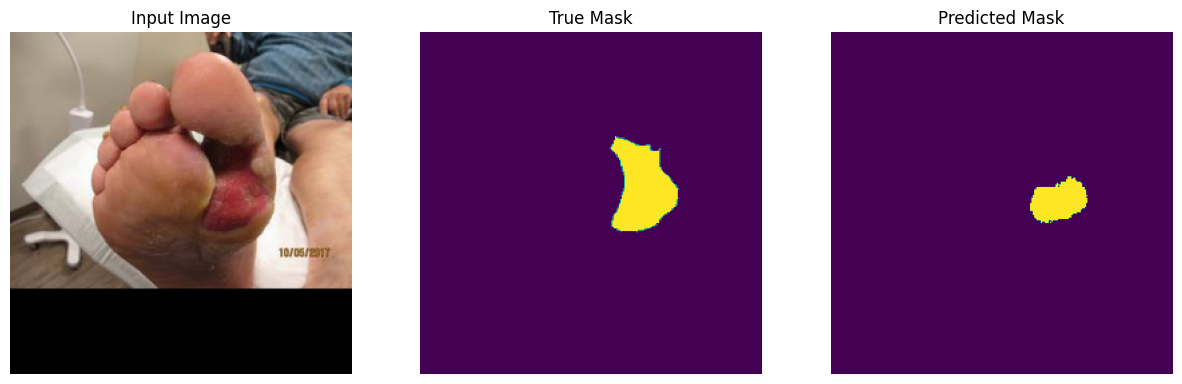

In [ ]:
# Calling the predict function
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/train/images/0011.png')
# true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Ulcer2/test/images/b586407933e66b112820f28448783627_0.png')
# true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Ulcer/test/images/ba4755da013537410deae3f8386d08ba_1.png')
# true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Ulcer/test/images/b61269467f2dc93f3cc31f933fa7013a_0.png')
# true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Ulcer/test/images/b712446cdd649dcb735673f7322daa69_0.png')
# true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Ulcer/test/images/cb17569424d3c73fe71071ad8166acf2_0.png')

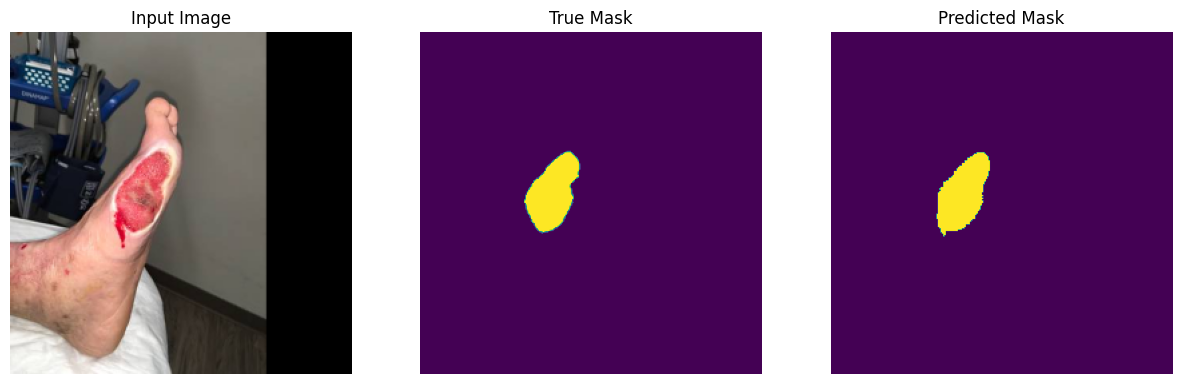

In [ ]:
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/Foot Ulcer Segmentation Challenge/train/images/0242.png')

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 2
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    # Uncomment this when you want to print the mean IoU
    print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
IoU(true_mask, pred_mask)

class 00: #TP= 63142, #FP=  1370, #FN=    1, IoU=0.979
class 01: #TP=  1020, #FP=     4, #FN= 1234, IoU=0.452
Mean IoU: 0.715


0.7152378307531263

In [ ]:
import numpy as np
import math

def dice_score(y_i, y_pred):
    """
    This function calculates the mean Dice Score.
    Dice Score = 2 * TP / (2 * TP + FP + FN)
    """
    dice_scores = []
    n_classes = int(np.max(y_i)) + 1  # Convert to integer and set to the number of classes present in y_i
    # n_classes=WRITE NUMBER OF CLASS
    print(f"Number of classes: {n_classes}")  # Debugging line to ensure n_classes is correct

    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c) & (y_pred == c))
        # Calculating the False Positives
        FP = np.sum((y_i != c) & (y_pred == c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c) & (y_pred != c))
        # Calculating the Dice Score for the particular class
        dice = (2 * TP) / float((2 * TP) + FP + FN)
        # Printing the outputs
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, Dice={:4.3f}".format(c, TP, FP, FN, dice))
        # Appending the Dice score to the list
        if math.isnan(dice):
            dice_scores.append(0)
            continue
        dice_scores.append(dice)

    # Calculating the mean Dice Score
    mean_dice = np.mean(dice_scores)
    print("Mean Dice Score: {:4.3f}".format(mean_dice))  # This should print the final mean dice score
    return mean_dice


In [ ]:
dice_score(true_mask, pred_mask)

Number of classes: 2
class 00: #TP= 63142, #FP=  1370, #FN=    1, Dice=0.989
class 01: #TP=  1020, #FP=     4, #FN= 1234, Dice=0.622
Mean Dice Score: 0.806


0.8057954022994549